In [ ]:
####################################
#ENVIRONMENT SETUP

In [4]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py

In [30]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [34]:
def GetPlottingDirectory(plotFileName, plotType):
    plottingDirectory = mainCodeDirectory=os.path.join(mainDirectory,"Code","PLOTTING")
    
    specificPlottingDirectory = os.path.join(plottingDirectory, plotType)
    os.makedirs(specificPlottingDirectory, exist_ok=True)

    plottingFileName=os.path.join(specificPlottingDirectory, plotFileName)

    return plottingFileName

In [6]:
#IMPORT CLASSES (from current directory)
sys.path.append(os.path.join(mainCodeDirectory,"Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, DataManager_Class

In [7]:
import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

In [8]:
####################################
#LOADING CLASSES

In [9]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str, #just need this one for the data loading function
                                ModelData.Np_str, dataType="Figures", dataName="Figures", dtype="float32")

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/Figures
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project

In [10]:
####################################
#SPECIFIC LIBRARIES

In [11]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.lines as mlines

In [12]:
####################################
#FUNCTIONS

In [13]:
#general functions
ocean_fraction=1/4
def PlotLandCoast(ax, ocean_fraction=ocean_fraction, linewidth=10,alpha=0.6,correction=0.003):
    xh=ModelData.xh-ModelData.xh[0]
    ax.axvline(x=xh[-1] * ocean_fraction, color='black', linewidth=3, label='Coastline')
    # Add land and sea colors
    seacolor = (0, 89 / 255, 179 / 255)
    landcolor = (139 / 255, 69 / 255, 19 / 255)
    ax.axhline(y=0, xmin=0, xmax=ocean_fraction-correction, color=seacolor, linewidth=linewidth,alpha=alpha)
    ax.axhline(y=0, xmin=ocean_fraction+correction, xmax=1, color=landcolor, linewidth=linewidth,alpha=alpha)

def GetMeanData(variableName,t_level,z_level):
    timeString = ModelData.timeStrings[t_level]
    dataVariable = DataManager.GetTimestepData(DataManager.inputDataDirectory, timeString, variableName=variableName)
    dataVariable_zyx = dataVariable[z_level]
    dataVariable_zx_mean = np.mean(dataVariable_zyx, axis=1)
    return dataVariable_zx_mean

In [14]:
################################################################################################################
#CONFIGURATION PLOTTING FUNCTIONS

In [15]:
def PlotGridStretching():
    zf = ModelData.zf;zhs = ModelData.zh
    zf_diff = np.diff(zf)*1000
    fig = plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig)
    ax0 = fig.add_subplot(gs[0, 0]); ax1 = fig.add_subplot(gs[0, 1]) 
    
    ax0.set_xlabel('Vertical Level Index');ax0.set_ylabel('z (km)')
    ax1.set_xlabel('Δz');ax1.set_ylabel('z (km)')
    ax0.plot(np.arange(len(zf)), zf, color='black');ax0.set_title('z Level Heights (kms)')
    ax1.plot(zf_diff,zhs, color='black');ax1.set_title('Grid Spacing (m)')

    axes=[ax0,ax1]
    SnapLimitsToTicks(axes, dim="x")
    SnapLimitsToTicks(axes, dim="y")
    for ax in axes:
        ax.set_ylim(zf.min(),zf.max());

In [16]:
#2D CONFIGURATION PLOT
def plot_domain_configuration(ax, ocean_fraction=ocean_fraction, bottom=0, top=200, left=0, right=512):
    center = left + ((right - left) * ocean_fraction)
    mid_y = (bottom + top) / 2  # Middle of y-axis for text

    # Axis labels and title
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_title(f'Domain Configuration')

    ax.set_xlim(left, right)
    ax.set_xticks([left, right])

    ax.set_ylim(bottom, top)
    ax.set_yticks([bottom, top])

    # Colors
    seacolor = (0, 89/255, 179/255)
    landcolor = (139/255, 69/255, 19/255)

    # Text labels with vertical centering
    ax.text((left + center) / 2, mid_y, 'Sea', va='center', ha='center')
    ax.axvspan(left, center, color=seacolor, alpha=0.3)

    ax.text((right + center) / 2 - 10, mid_y, 'Land', va='center', ha='center')
    ax.axvspan(center, right, color=landcolor, alpha=0.3)

    # Center line
    ax.axvline(x=center, color='black', linewidth=3)

# #PLOTTING
# fig, ax = plt.subplots(figsize=(10, 2))  # Aspect ratio 5 means height = width/5
# plot_domain_configuration(ax)

In [17]:
#3D CONFIGURATION PLOT
ocean_fraction=2/8
def get_corners(x_max, y_max, z_max):
    """Define 8 corners of the 3D box."""
    return np.array([
        [0, 0, 0],
        [x_max, 0, 0],
        [x_max, y_max, 0],
        [0, y_max, 0],
        [0, 0, z_max],
        [x_max, 0, z_max],
        [x_max, y_max, z_max],
        [0, y_max, z_max],
    ])


def get_edges(corners):
    """Return list of 12 edges as pairs of corner points."""
    return [
        [corners[0], corners[1]],
        [corners[1], corners[2]],
        [corners[2], corners[3]],
        [corners[3], corners[0]],
        [corners[4], corners[5]],
        [corners[5], corners[6]],
        [corners[6], corners[7]],
        [corners[7], corners[4]],
        [corners[0], corners[4]],
        [corners[1], corners[5]],
        [corners[2], corners[6]],
        [corners[3], corners[7]],
    ]


def plot_box_edges(ax, edges):
    """Plot the box edges as black lines."""
    box_lines = Line3DCollection(edges, colors='black', linewidths=1.5)
    ax.add_collection3d(box_lines)


def configure_ticks_and_hide_hashes(ax, x_max, y_max, z_max):
    """Set ticks locations, pad, and hide tick marks (hashes)."""
    ax.tick_params(axis='x', pad=2)
    ax.tick_params(axis='y', pad=-2)
    ax.tick_params(axis='z', pad=-2)

    ax.set_xticks(np.linspace(x_max, 0, 5))
    ax.set_yticks(np.linspace(y_max, 0, 5))
    ax.set_zticks(np.linspace(0, z_max, 6))

    ax.xaxis._axinfo['ticklabel_direction'] = -1  # default is 1
    ax.yaxis._axinfo['ticklabel_direction'] = -1
    ax.zaxis._axinfo['ticklabel_direction'] = -1

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['tick']['inward_factor'] = 0
        axis._axinfo['tick']['outward_factor'] = 0
        axis._axinfo['tick']['color'] = (0, 0, 0, 0)  # fully transparent

def plot_surface_planes(ax, x_max, y_max, ocean_fraction, seacolor, landcolor):
    """Plot translucent sea and land surface planes."""
    # Land surface
    xx, yy = np.meshgrid(
        np.linspace(x_max * ocean_fraction, x_max, 2),
        np.linspace(0, y_max, 2)
    )
    zz = np.zeros_like(xx)
    ax.plot_surface(xx, yy, zz, color=landcolor, alpha=0.3)

    # Sea surface
    xx, yy = np.meshgrid(
        np.linspace(0, x_max * ocean_fraction, 2),
        np.linspace(0, y_max, 2)
    )
    ax.plot_surface(xx, yy, zz, color=seacolor, alpha=0.3)


def add_surface_labels(ax, x_max, y_max, ocean_fraction):
    """Add text labels 'Sea' and 'Land' slightly above surfaces."""
    ax.text(
        x_max * ocean_fraction / 2 - 20,
        y_max / 2 + 20,
        0.1,
        'Sea',
        color='blue',
        fontsize=12,
        fontfamily='sans-serif',
        weight='normal'
    )
    ax.text(
        x_max * ocean_fraction + (x_max - x_max * ocean_fraction) / 2 - 20,
        y_max / 2 + 20,
        0.1,
        'Land',
        color='brown',
        fontsize=12,
        fontfamily='sans-serif',
        weight='normal'
    )


def set_axis_labels_and_view(ax):
    """Set axis labels with custom padding and view angle."""
    ax.set_xlabel('x (km)', labelpad=-33)
    ax.set_ylabel('y (km)', labelpad=-27)
    ax.set_zlabel('z (km)', labelpad=-25)

    # Rotate view so Y axis is on left
    ax.view_init(elev=20, azim=50)


def plot_domain_3d(ax,x_max=512, y_max=200, z_max=25, ocean_fraction=ocean_fraction):
    """Main plotting function assembling all parts."""

    # Colors
    seacolor = (0, 89 / 255, 179 / 255)
    landcolor = (139 / 255, 69 / 255, 19 / 255)

    # Setup box corners and edges
    corners = get_corners(x_max, y_max, z_max)
    edges = get_edges(corners)

    # Plot box edges
    plot_box_edges(ax, edges)

    # Set axis limits (reversed axes)
    ax.set_xlim(x_max, 0)
    ax.set_ylim(y_max, 0)
    ax.set_zlim(0, z_max)

    # Control aspect ratio (X:Y:Z)
    # ax.set_box_aspect([5, 2, 1])

    # Configure ticks and hide tick marks
    configure_ticks_and_hide_hashes(ax, x_max, y_max, z_max)

    # Plot translucent sea and land surfaces
    plot_surface_planes(ax, x_max, y_max, ocean_fraction, seacolor, landcolor)

    # Add 'Sea' and 'Land' labels
    add_surface_labels(ax, x_max, y_max, ocean_fraction)

    # Axis labels and view
    set_axis_labels_and_view(ax)

    # Tight layout and margins
    plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95)


def replace_z_ticks(ax, x_pos, y_pos, z_adj, z_max, num_ticks=6, offset=15):
    """Replace Z axis ticks with custom text at shifted 3D positions."""
    z_ticks = np.linspace(0, z_max, num_ticks)
    
    # Hide the default z tick labels
    ax.set_zticklabels([])
    
    # Add custom labels at shifted positions
    for z in z_ticks:
        ax.text(
            x_pos,             # Shifted x position (further into the box)
            y_pos,             # Shifted y position
            z+z_adj,                 # Actual z tick position
            f'{z:.0f}',        # Label text
            color='black',
            fontsize=10,
            ha='right',        # Horizontal alignment
            va='center'        # Vertical alignment
        )

        
# #PLOTTING
# fig = plt.figure(figsize=(8, 5))  # Size appropriate for 5:2 aspect
# gs = gridspec.GridSpec(1, 1)

# # Add subplot using gridspec
# ax = fig.add_subplot(gs[0], projection='3d')

# # Run your 3D plot function
# plot_domain_3d(ax)
# replace_z_ticks(ax, x_pos=-15, y_pos=200, z_max=25, num_ticks=6)

In [18]:
################################################################################################################
#PLOTTING FUNCTIONS

In [19]:
def plot_alongcoast_vertical_u(t, ocean_fraction, ax, maxlev=20, index_adjust=0, font_size=12, dpi=300):
    pad = 0
    
    zh_slice = slice(0, np.where(ModelData.zh < maxlev)[0][-1])
    alongcoast_w = GetMeanData('winterp', t, zh_slice)
    alongcoast_qv = GetMeanData('qv', t, zh_slice)
    alongcoast = GetMeanData('uinterp', t, zh_slice)

    # Limiting W Data Above Threshold Value
    alongcoast_w[alongcoast_w < 0.1] = 0  # Thresholding small values

    # Get Axis Data
    xh = ModelData.xh - ModelData.xh[0]
    yh = ModelData.zh[zh_slice]
    
    cmap='RdBu_r';cmap='bwr'
    c = ax.contourf(xh, yh, alongcoast, cmap='bwr', levels=20)
    cbar = fig.colorbar(c, ax=ax, pad=pad)
    cbar.set_label(r'$w\ (\mathrm{m\,s^{-1}}$)', fontsize=font_size)
    cbar.ax.yaxis.label.set_size(font_size)
    cbar.ax.tick_params(labelsize=font_size)

    ax.grid(True, linestyle=':', color='black')

    # Plot W and QV Contours
    contour_w = ax.contour(xh, yh, alongcoast_w, linestyles='dotted', linewidths=1.5, colors='black', alpha=0.75)

    contour_qv = ax.contour(xh, yh, alongcoast_qv * 1000, linewidths=1, colors='blue', alpha=0.75)
    ax.clabel(contour_qv, inline=True, fontsize=font_size, fmt='%1.1f', inline_spacing=5)

    # contour_qi = ax.contour(xh, yh, qi_data, linestyles='dashed', linewidths=1, colors='blue', alpha=0.75)

    # Get time information for labeling
    ([days, hours, mins], _) = get_time(ModelData.time, t + index_adjust, (0, 6, 0))
    # ax.set_title(f'Along-coast Vertical Plot at t = {t+index_adjust} = {days}:{hours}:{mins}', fontsize=font_size)

    # Legend handles
    handle_time = mlines.Line2D([], [], color='none', label=f't = {t+index_adjust} = {days}:{hours}:{mins}')
    handle_c = mlines.Line2D([], [], color='black', lw=3, label='Coastline')
    handle_qi = mlines.Line2D([], [], color='blue', linestyle='dashed', label=r'Ice ($q_i$)')
    handle_qv = mlines.Line2D([], [], color='blue', label=r'Water Vapor ($q_v$)')
    handle_w = mlines.Line2D([], [], color='black', linestyle='dotted',
                            label=f'Vertical Velocity (w) ' + r'(≥ 0.1 $\mathrm{m\,s}^{-1}$)')
    legend = ax.legend(handles=[handle_qv, handle_w, handle_c, handle_time], loc='upper right', fontsize=font_size)
    for text in legend.get_texts():
        text.set_fontsize(font_size)

    ax.set_xlabel('x (km)', fontsize=font_size)
    ax.set_ylabel('z (m)', fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_ylim(bottom=0)

    # Plot coastline
    PlotLandCoast(ax)

# # Example call
# t = 100 if ModelData.t_res == '5min' else 100 * 5
# channel_aspect_ratio = 5
# figwidth = 25
# dpi=50
    
# fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(figwidth, figwidth / channel_aspect_ratio), dpi=dpi)
# plot_alongcoast_vertical_u(t, ocean_fraction, axes)

# # # Save figure
# # save_path = os.path.join(folder_path, "verticalu.jpg")
# # plt.savefig(save_path, dpi=dpi)
# # # plt.close(fig)
# # # print(f"Figure saved at {save_path}")

In [20]:
def plot_single_horizontal_wind(t, ax, var, title, c_label, ocean_fraction, font_size=12, index_adjust=0):
    zlev = 3  # Vertical level

    # Get data
    field_tzyx = DataManager.GetTimestepData(DataManager.inputDataDirectory, timeString=ModelData.timeStrings[t], variableName=var)
    field = field_tzyx[zlev]

    # Normalize with balanced vmin and vmax
    n_levels = 15
    vmin = -np.max(abs(field))
    vmax = np.max(abs(field))
    levels = np.linspace(vmin, vmax, n_levels)
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=n_levels)
    cmap = plt.get_cmap('bwr', n_levels)

    # Axis coordinates
    xh = ModelData.xh - ModelData.xh[0]
    yh = ModelData.yh - ModelData.yh[0]

    # Plot contourf
    contour = ax.contourf(xh, yh, field, cmap=cmap, norm=norm, levels=levels)
    cbar = plt.colorbar(contour, ax=ax, pad=0)
    cbar.set_label(c_label, fontsize=font_size)
    cbar.ax.tick_params(labelsize=font_size)
    cbar.ax.yaxis.label.set_size(font_size)

    # Plot coastline
    
    ax.axvline(x=xh[-1] * ocean_fraction, color='black', linewidth=3, label='Coastline')

    # Get time info
    ([days, hours, mins], _) = get_time(ModelData.time, t + index_adjust, (0, 6, 0))
    value = ModelData.zh[zlev]

    # Legend
    handle_time = mlines.Line2D([], [], color='none', label=f't = {t+index_adjust} = {days}:{hours}:{mins}')
    handle_z = mlines.Line2D([], [], color='none', label= f'z = {ModelData.zh[zlev].item()*1000:.0f} m')
    handle_c = mlines.Line2D([], [], color='black', lw=3, label='Coastline')
    legend = ax.legend(handles=[handle_c, handle_time, handle_z], loc='upper right', fontsize=font_size)
    for text in legend.get_texts():
        text.set_fontsize(font_size)

    # Labels and ticks
    ax.set_xlabel('x (km)', fontsize=font_size)
    ax.set_ylabel('y (km)', fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    
# # Example call
# t = 100 if ModelData.t_res == '5min' else 100 * 5
# channel_aspect_ratio = 5
# figwidth = 25
# dpi = 50

# # Create figure and gridspec
# fig = plt.figure(figsize=(figwidth, figwidth / channel_aspect_ratio * 2), dpi=dpi)
# gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.25)

# # Create subplots
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[1, 0])

# # Plot both wind variables
# plot_single_horizontal_wind(t, ax1, 'winterp', 'Horizontal Plot of Vertical Velocity', r'$w\ (m\ s^{-1})$', ocean_fraction, index_adjust=0)
# plot_single_horizontal_wind(t, ax2, 'uinterp', 'Horizontal Plot of Zonal Wind', r'$u\ (m\ s^{-1})$', ocean_fraction, index_adjust=0)

# # Optional: Save figure
# # save_path = os.path.join(folder_path, "horizontalw-u_combined.jpg")
# # plt.savefig(save_path, dpi=dpi)
# # # print(f"Figure saved at {save_path}")

In [21]:
def plot_alongcoast_water_vapor(t, ocean_fraction, ax, maxlev=5, index_adjust=0, dpi=300):
    pad=0

    zh_slice=slice(0, np.where(ModelData.zh < maxlev)[0][-1])
    alongcoast = GetMeanData('qv',t,zh_slice)

    #Get Axis Data
    xh=ModelData.xh-ModelData.xh[0]
    yh=ModelData.zh[zh_slice]
    
    c = ax.contourf(xh,yh,alongcoast, cmap='Blues', levels=15)
    cbar = fig.colorbar(c, ax=ax, pad=pad)
    cbar.set_label(r'$kg\ kg^{-1}$')
    ax.grid(True, linestyle=':', color='black')

    # Plot coastline
    PlotLandCoast(ax)

    # Get time information for labeling
    ([days, hours, mins], _) = get_time(ModelData.time, t + index_adjust, (0, 6, 0))

    ax.set_title(f'Along-coast Vertical Plot of Water Vapor Mixing Ratio at t = {t+index_adjust} = {days}:{hours}:{mins}')
    ax.legend(loc='upper right')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('z (m)')
    ax.set_ylim(bottom=0)

# # Example call
# t = 100 if ModelData.t_res == '5min' else 100 * 5
# channel_aspect_ratio = 5
# figwidth = 25
# dpi = 50

# fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(figwidth, figwidth / channel_aspect_ratio), dpi=dpi)
# plot_alongcoast_water_vapor(t, ocean_fraction, axes)

In [22]:
def plot_alongcoast_clouds(t, ocean_fraction, ax, maxlev=20, index_adjust=0, font_size=12, dpi=300):
    pad = 0

    zh_slice = slice(0, np.where(ModelData.zh < maxlev)[0][-1])
    alongcoast_w = GetMeanData('winterp', t, zh_slice)
    alongcoast_qv = GetMeanData('qv', t, zh_slice)
    qc_data = GetMeanData('qc', t, zh_slice)
    qi_data = GetMeanData('qi', t, zh_slice)
    alongcoast = (qc_data + qi_data) * 1000

    # Limiting W Data Above Threshold Value
    alongcoast_w[alongcoast_w < 0.1] = 0  # Thresholding small values

    # Limiting QCQI Data Above Threshold Value
    alongcoast[alongcoast < 1e-6] = 0  # Thresholding small values

    # Get Axis Data
    xh = ModelData.xh - ModelData.xh[0]
    yh = ModelData.zh[zh_slice]

    c = ax.contourf(xh, yh, alongcoast, cmap='Blues', levels=15)
    cbar = fig.colorbar(c, ax=ax, pad=pad)
    cbar.set_label(r'$q_c + q_i\ (\mathrm{kg\,kg^{-1}}$)', fontsize=font_size)
    cbar.ax.yaxis.label.set_size(font_size)
    cbar.ax.tick_params(labelsize=font_size)

    ax.grid(True, linestyle=':', color='black')

    # Plot W and QV Contours
    contour_w = ax.contour(xh, yh, alongcoast_w, linestyles='dotted', linewidths=1.5, colors='black', alpha=0.75)

    contour_qv = ax.contour(xh, yh, alongcoast_qv * 1000, linewidths=1, colors='blue', alpha=0.75)
    ax.clabel(contour_qv, inline=True, fontsize=font_size, fmt='%1.1f', inline_spacing=5)

    contour_qi = ax.contour(xh, yh, qi_data, linestyles='dashed', linewidths=1, colors='blue', alpha=0.75)

    # Plot coastline
    PlotLandCoast(ax)

    # Get time information for labeling
    ([days, hours, mins], _) = get_time(ModelData.time, t + index_adjust, (0, 6, 0))
    # ax.set_title(f'Along-coast Vertical Plot at t = {t+index_adjust} = {days}:{hours}:{mins}', fontsize=font_size)

    # Legend handles
    handle_time = mlines.Line2D([], [], color='none', label=f't = {t+index_adjust} = {days}:{hours}:{mins}')
    handle_c = mlines.Line2D([], [], color='black', lw=3, label='Coastline')
    handle_qi = mlines.Line2D([], [], color='blue', linestyle='dashed', label=r'Ice ($q_i$)')
    handle_qv = mlines.Line2D([], [], color='blue', label=r'Water Vapor ($q_v$)')
    handle_w = mlines.Line2D([], [], color='black', linestyle='dotted',
                            label=f'Vertical Velocity (w) ' + r'(≥ 0.1 $\mathrm{m\,s}^{-1}$)')
    legend = ax.legend(handles=[handle_qv, handle_qi, handle_w, handle_c, handle_time], loc='upper right', fontsize=font_size)
    for text in legend.get_texts():
        text.set_fontsize(font_size)

    ax.set_xlabel('x (km)', fontsize=font_size)
    ax.set_ylabel('z (m)', fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_ylim(bottom=0)

# # Example call
# t = 100 if ModelData.t_res == '5min' else 100 * 5
# channel_aspect_ratio = 5
# figwidth = 25
# dpi = 50

# fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(figwidth, figwidth / channel_aspect_ratio), dpi=dpi)
# plot_alongcoast_clouds(t, ocean_fraction, axes)

In [23]:
################################################################################################################
#PLOTTING FIGURES

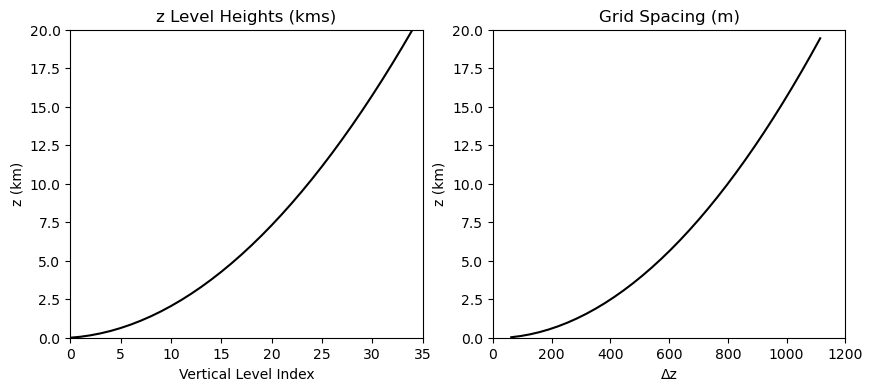

In [24]:
#GRID STRETCHING
PlotGridStretching()

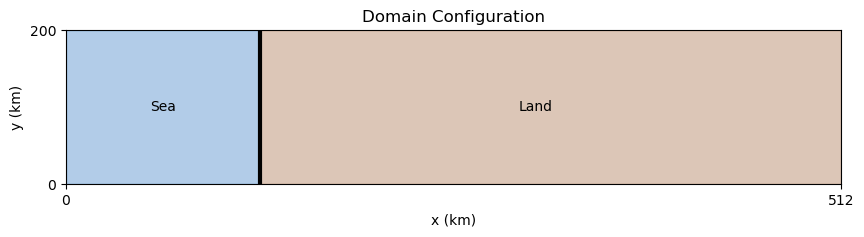

In [25]:
#DOMAIN CONFIGURATION ONE
fig, ax = plt.subplots(figsize=(10, 2))  # Aspect ratio 5 means height = width/5
plot_domain_configuration(ax)

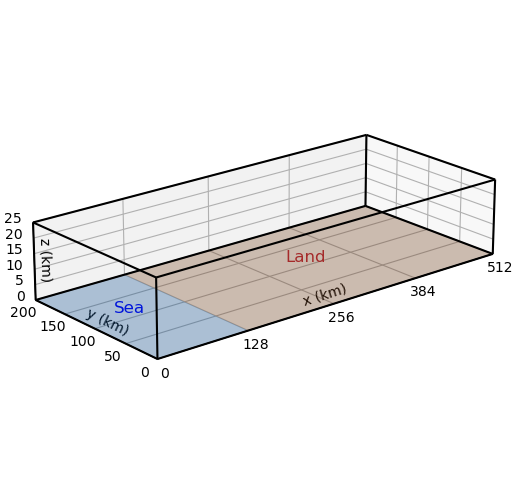

In [26]:
#DOMAIN CONFIGURATION TWO
fig = plt.figure(figsize=(8, 5))  # Size appropriate for 5:2 aspect
gs = gridspec.GridSpec(1, 1)

# Add subplot using gridspec
ax = fig.add_subplot(gs[0], projection='3d')

# Run your 3D plot function
plot_domain_3d(ax)
replace_z_ticks(ax, x_pos=-15, y_pos=200, z_adj=2, z_max=25, num_ticks=6)
ax.set_box_aspect([512, 230, 95])  # x:y:z ratio, y is twice taller
# ax.set_title("Domain Configuration")

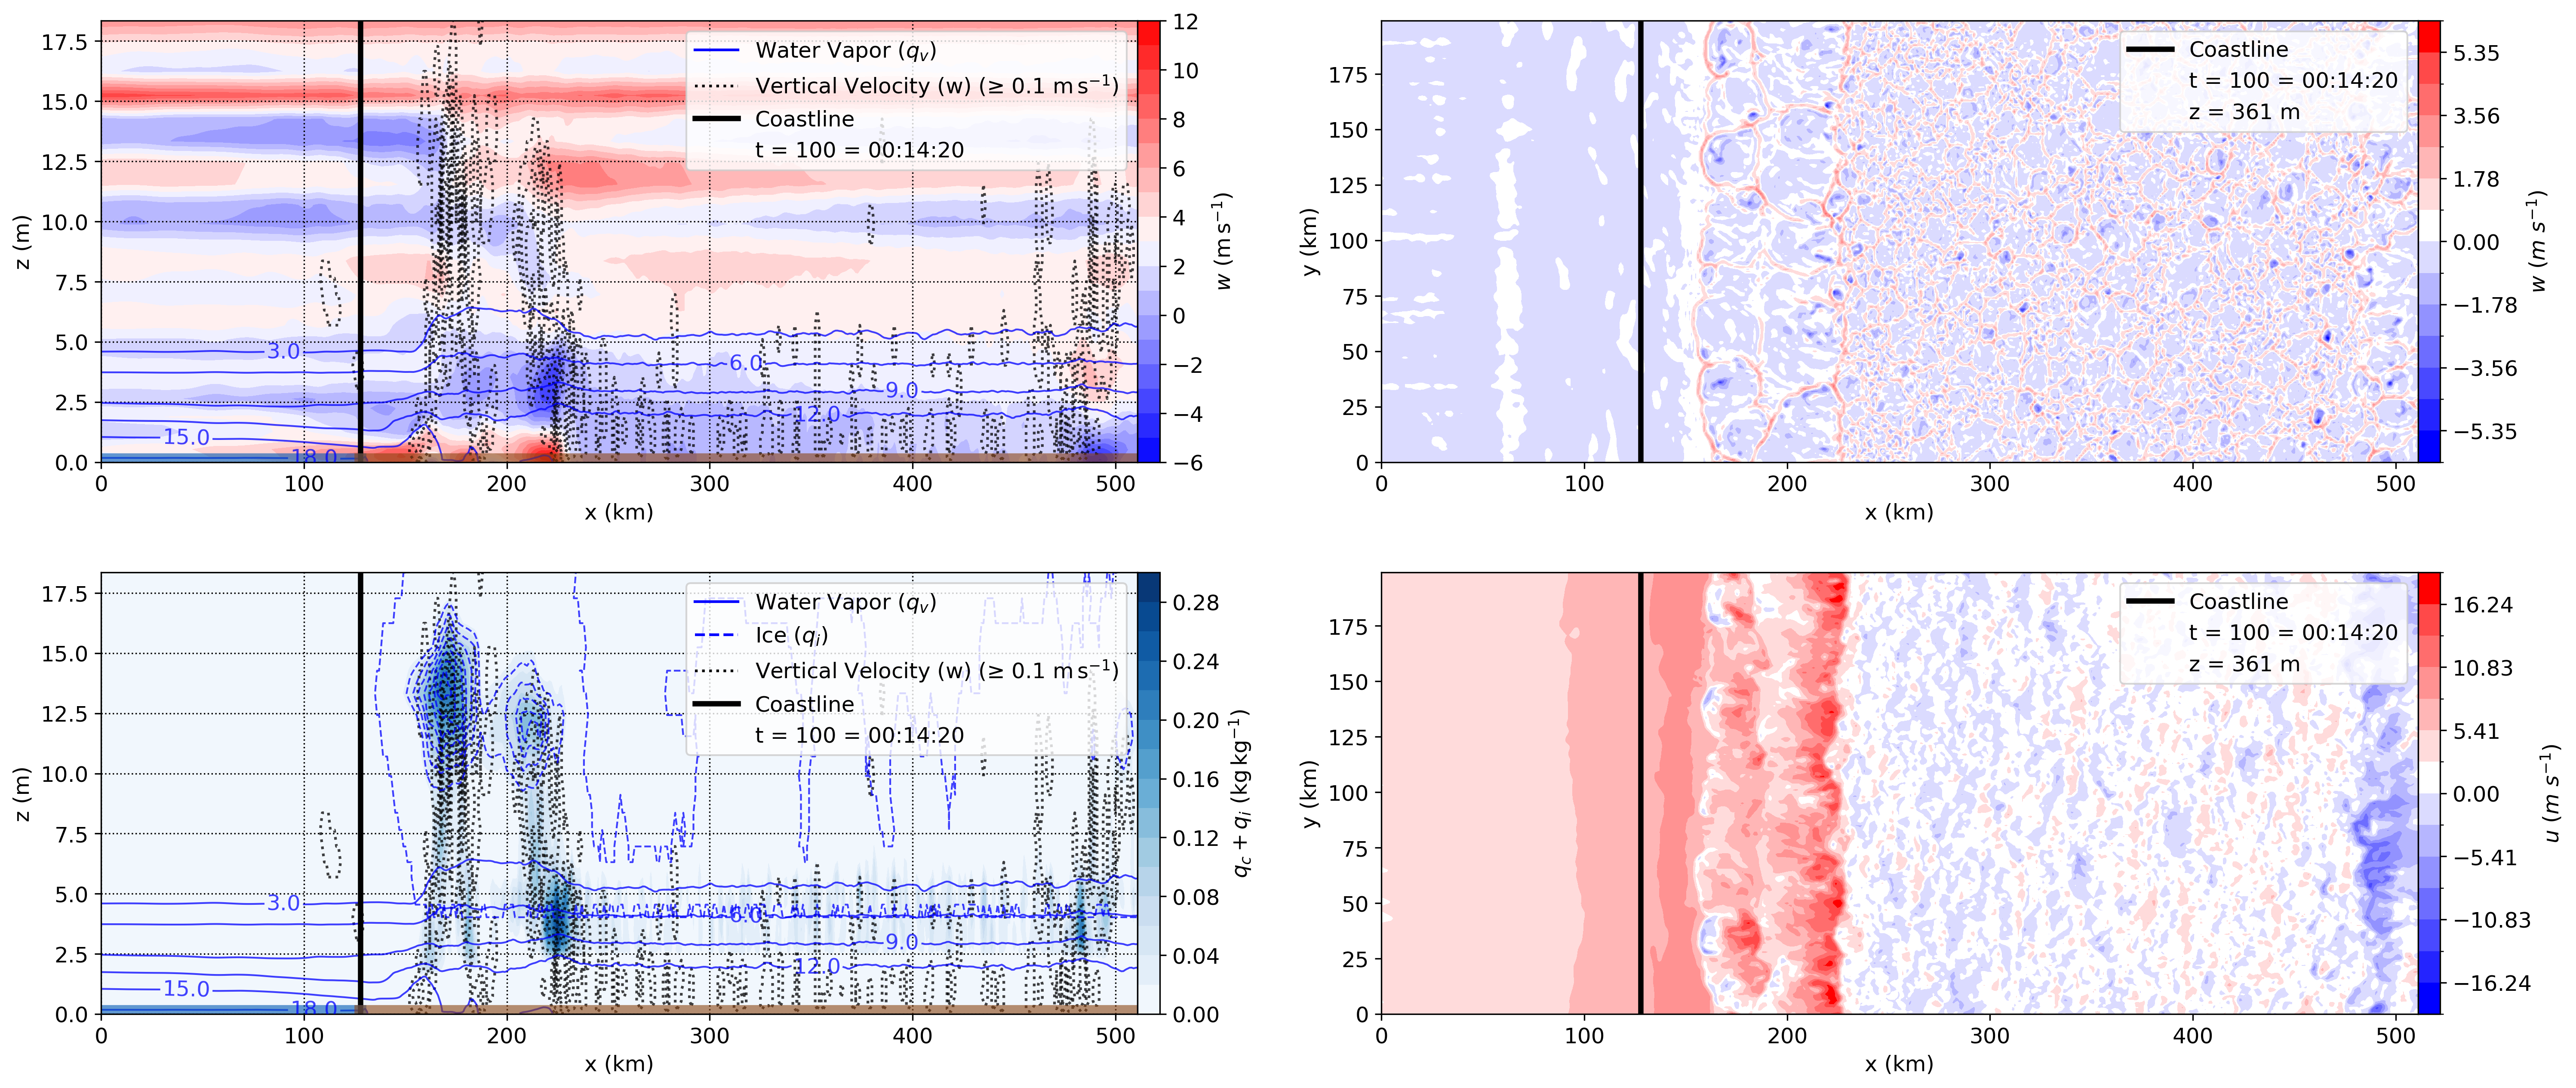

In [35]:
#COMBINED DOMAIN PLOTS
t = 100 if ModelData.t_res == '5min' else 100 * 5
channel_aspect_ratio = 5
figwidth = 25
dpi = 300

# Create figure and 2x2 gridspec
fig = plt.figure(figsize=(figwidth, figwidth / channel_aspect_ratio * 2), dpi=dpi)
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1, 1], width_ratios=[1, 1], hspace=0.25, wspace=0.05)

# Create subplots
ax_v_u  = fig.add_subplot(gs[0, 0])  # Top-left: vertical U
ax_v_qv = fig.add_subplot(gs[1, 0])  # Bottom-left: vertical qv
ax_h_w  = fig.add_subplot(gs[0, 1])  # Top-right: horizontal w
ax_h_u  = fig.add_subplot(gs[1, 1])  # Bottom-right: horizontal u

# Plotting
plot_alongcoast_vertical_u(t, ax=ax_v_u, ocean_fraction=ocean_fraction, dpi=dpi, index_adjust=0, font_size=12)
plot_alongcoast_clouds(t, ocean_fraction, ax=ax_v_qv, dpi=dpi, index_adjust=0, font_size=12)

plot_single_horizontal_wind(t, ax_h_w, 'winterp', 'Horizontal Plot of Vertical Velocity', r'$w\ (m\ s^{-1})$', ocean_fraction, index_adjust=0)
plot_single_horizontal_wind(t, ax_h_u, 'uinterp', 'Horizontal Plot of Zonal Wind', r'$u\ (m\ s^{-1})$', ocean_fraction, index_adjust=0)

#SAVING
plotFileName = f"Initial_ContourPlots_{ModelData.res}_{ModelData.t_res}_{ModelData.Np_str}.jpg"
plottingFileName = GetPlottingDirectory(plotFileName, plotType="Figures")
fig.savefig(plottingFileName, dpi=300, bbox_inches='tight')